In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

con = sqlite3.connect(r'D:\Data science\Data sets\amazon-fine-food-reviews\database.sqlite')

C:\Users\Manju\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#1.selecting only Score and summary columns from the table except score 3
# because we are seperating the data which has score 4 and 5 as positive and 1 and 2 as positive

messages = pd.read_sql_query("""
SELECT Score, Summary
FROM Reviews
WHERE Score != 3
""", con)


def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

Score = messages['Score']
Score = Score.map(partition)
Summary = messages['Summary']
X_train, X_test, y_train, y_test = train_test_split(Summary, Score, test_size=0.2, random_state=42)

In [3]:
stemmer = PorterStemmer()
from nltk.corpus import stopwords

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    #tokens = [word for word in tokens if word not in stopwords.words('english')]
    stems = stem_tokens(tokens, stemmer)
    return ' '.join(stems)

intab = string.punctuation
outtab = "                                "
trantab = str.maketrans(intab, outtab)

#--- Training set

corpus = []
for text in X_train:
    text = text.lower()
    text = text.translate(trantab)
    text=tokenize(text)
    corpus.append(text)
        
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(corpus)        
        
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#--- Test set

test_set = []
for text in X_test:
    text = text.lower()
    text = text.translate(trantab)
    text=tokenize(text)
    test_set.append(text)

X_new_counts = count_vect.transform(test_set)
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

#from pandas import *
#df = DataFrame({'Before': X_train, 'After': corpus})
#print(df.head(20))

prediction = dict()

<b>3.a  Multinomial Naive bayes </b>

In [4]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train_tfidf, y_train)
prediction['Multinomial'] = model.predict(X_test_tfidf)
accuracyMultinomial = metrics.accuracy_score(prediction['Multinomial'],y_test)

In [5]:
print("Accuracy of MultinomialNB is:",accuracyMultinomial,'\n')
print(metrics.classification_report(y_test, prediction['Multinomial'], target_names = ["positive", "negative"]))

Accuracy of MultinomialNB is: 0.903673345188 

             precision    recall  f1-score   support

   positive       0.86      0.45      0.59     16379
   negative       0.91      0.99      0.95     88784

avg / total       0.90      0.90      0.89    105163



<b>Precision:</b> It is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

<b>Recall:</b> It is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

<b>F1-score:</b> It can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

[[ 7406  8973]
 [ 1157 87627]]


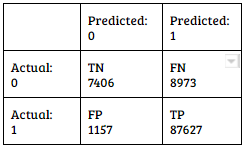

In [6]:
from IPython.display import Image
print(metrics.confusion_matrix(y_test,prediction['Multinomial']))
Image(filename='D:\Data science\Images\CMMultinomialNB.png')

<h4>Basic Terminologies</h4>

<b>True Positives(TP):</b>we correctly predicted that they do belongs to positive class.In this case we predicted 87627 times correctly as positive reviews 

<b>True Negatives(TN):</b>We correctly predicted that they belongs to negative class.In this case we predicted 7406 times correctly as negative reviews 

<b>False Positives(FP):</b>We incorrectly predicted that they do belongs to positive class(a “Type I error”)In this case we predicted 1157 times in correctly as positive reviews 

<b>False Negative(FN):</b>We incorrectly predicted that they do belongs to negative class.(a”Type II error”)In this case we predicted 8973 times in correctly as negative reviews 

In [7]:
#Bernoulli Naive bayes with Accuracy,classification report,and confusion matrix

Accuracy of BernoulliNB is: 0.907495982427 

             precision    recall  f1-score   support

   positive       0.73      0.65      0.69     16379
   negative       0.94      0.96      0.95     88784

avg / total       0.90      0.91      0.91    105163

[[10579  5800]
 [ 3928 84856]]


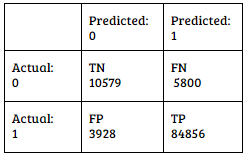

In [8]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB().fit(X_train_tfidf, y_train)
prediction['Bernoulli'] = model.predict(X_test_tfidf)
accuracyBernoulli = metrics.accuracy_score(prediction['Bernoulli'],y_test)

print("Accuracy of BernoulliNB is:",accuracyBernoulli,'\n')
print(metrics.classification_report(y_test, prediction['Bernoulli'], target_names = ["positive", "negative"]))

print(metrics.confusion_matrix(y_test,prediction['Bernoulli']))
Image(filename='D:\Data science\Images\CMBernouliNB.png')

<b>True Positives(TP):</b>In this case we predicted 84856 times correctly as positive reviews 

<b>True Negatives(TN):</b>In this case we predicted 10579 times correctly as negative reviews 

<b>False Positives(FP):</b>In this case we predicted 3928 times in correctly as positive reviews 

<b>False Negative(FN):</b>In this case we predicted 5800 times in correctly as negative reviews 

<b>4 a. Use Logistic Regression sklearn function to classify the statements into +ve and -ve statements</b>

Accuracy for Logistic regresion without penalty: 0.924878521914
             precision    recall  f1-score   support

   positive       0.83      0.65      0.73     16379
   negative       0.94      0.98      0.96     88784

avg / total       0.92      0.92      0.92    105163

[[10697  5682]
 [ 2218 86566]]


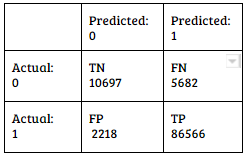

In [9]:
#Logistic Regression without any penality 
from sklearn import linear_model
logreg = linear_model.LogisticRegression()
logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)
accuracyLogistic1 = metrics.accuracy_score(prediction['Logistic'],y_test)

print("Accuracy for Logistic regresion without penalty:",accuracyLogistic1)
print(metrics.classification_report(y_test, prediction['Logistic'], target_names = ["positive", "negative"]))
print(metrics.confusion_matrix(y_test,prediction['Logistic']))
Image(filename='D:\Data science\Images\CMLogisticDefault.png')

<font face="verdana" color="green" span style="font-weight:bold">Observation :</font>

<b>Accuracy          :</b> for logistic regression with defualt implemention of sk learn is 92.48%</p>

<b>True Positives(TP):</b>In this case we predicted 84866 times correctly as positive reviews 

<b>True Negatives(TN):</b>In this case we predicted 10697 times correctly as negative reviews 

<b>False Positives(FP):</b>In this case we predicted 2218 times in correctly as positive reviews 

<b>False Negative(FN):</b>In this case we predicted 5682 times in correctly as negative reviews 

<b>4 b. Logistic regression with the use of L1 and L2 regularisers and do the grid search on c=1/λ</b>

In [10]:
#Logistic Regression with penality l2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [1,2,3,4,5,6,7,8,9,10] }
LogisticL2 = GridSearchCV(LogisticRegression(penalty='l2'), param_grid,cv=10)
LogisticL2.fit(X_train_tfidf,y_train)
print("Best score:",LogisticL2.best_score_,"Best estimator:",LogisticL2.best_estimator_,"best Params:",LogisticL2.best_params_)

Best score: 0.927353078918 Best estimator: LogisticRegression(C=8, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) best Params: {'C': 8}


<font face="verdana" color="green" span style="font-weight:bold">Results :</font>
The above results show us that for c=8 the accuracy is found to be highest across all the c values ranging between 1 to 10. So by choosing that c and l2 regulariser we will find the confusion matrix,Precision,Recall and F1 score 

Accuracy for Logistic regresion with penalty L2: 0.927522037218
             precision    recall  f1-score   support

   positive       0.82      0.69      0.75     16379
   negative       0.94      0.97      0.96     88784

avg / total       0.92      0.93      0.92    105163

[[11236  5143]
 [ 2479 86305]]


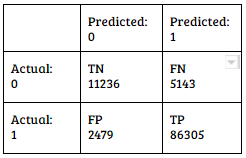

In [11]:
logregL2 = linear_model.LogisticRegression(penalty='l2',C=8)
logregL2.fit(X_train_tfidf, y_train)
prediction['LogisticL2'] = logregL2.predict(X_test_tfidf)
accuracyLogisticL2 = metrics.accuracy_score(prediction['LogisticL2'],y_test)

print("Accuracy for Logistic regresion with penalty L2:",accuracyLogisticL2)
print(metrics.classification_report(y_test, prediction['LogisticL2'], target_names = ["positive", "negative"]))
print(metrics.confusion_matrix(y_test,prediction['LogisticL2']))
Image(filename='D:\Data science\Images\CMLogisticL2.png')

In [12]:
#Logistic Regression with penality l1
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [1,2,3,4,5,6,7,8,9,10] }
LogisticL1 = GridSearchCV(LogisticRegression(penalty='l1'), param_grid,cv=10)
LogisticL1.fit(X_train_tfidf,y_train)
print("Best score:",LogisticL1.best_score_,"Best estimator:",LogisticL1.best_estimator_,"best Params:",LogisticL1.best_params_)

Best score: 0.927103465818 Best estimator: LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) best Params: {'C': 3}


<font face="verdana" color="green" span style="font-weight:bold">Results :</font>
The above results show us that for c=3 the accuracy is found to be highest across all the c values ranging between 1 to 10. So by choosing that c and l1 regulariser we will find the confusion matrix,Precision,Recall and F1 score 

Accuracy for Logistic regresion with penalty L1: 0.927388910548
             precision    recall  f1-score   support

   positive       0.82      0.68      0.75     16379
   negative       0.94      0.97      0.96     88784

avg / total       0.92      0.93      0.92    105163

[[11204  5175]
 [ 2461 86323]]


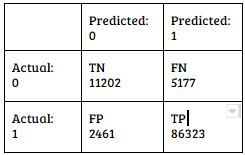

In [13]:
logregL1 = linear_model.LogisticRegression(penalty='l1',C=3)
logregL1.fit(X_train_tfidf, y_train)
prediction['LogisticL1'] = logregL1.predict(X_test_tfidf)
accuracyLogisticL1 = metrics.accuracy_score(prediction['LogisticL1'],y_test)

print("Accuracy for Logistic regresion with penalty L1:",accuracyLogisticL1)
print(metrics.classification_report(y_test, prediction['LogisticL1'], target_names = ["positive", "negative"]))
print(metrics.confusion_matrix(y_test,prediction['LogisticL1']))
Image(filename='D:\Data science\Images\CMLogisticL1.png')

<font face="verdana" color="green" span style="font-weight:bold">Observation :</font>
<p>1.The grid search value of c for model with l2 penality is found to be 8 </p>
<p>2.With c=8 the accuracy for logistic regression is 92.75 %</p>
<p>3.The grid search value of c for model with l1 penality is found to be 3 </p>
<p>4.With c=3 the accuracy for logistic regression is 92.73 %</p>
<p>5.From above two c values and regularisers its found that c=8  and l2 regulariser gives us the highest accuracy.So we will use this c and l2 for feature imporatance for logistic regression </p>

<b>4.c Feature importance for Logistic regresion </b>

In [31]:
#Selecting top 100 words from the corpus list
word_features = nltk.FreqDist(corpus)
topwords = [fpair[0] for fpair in list(word_features.most_common(100))]
print (word_features.most_common(25))

[('delici', 5074), ('yummi', 3592), ('great product', 3038), ('yum', 2508), ('love it', 2174), ('great', 1929), ('excel', 1709), ('good stuff', 1586), ('great coffe', 1455), ('awesom', 1430), ('the best', 1337), ('great tast', 1296), ('amaz', 1044), ('veri good', 1037), ('tasti', 1004), ('disappoint', 958), ('great stuff', 895), ('excel product', 878), ('great tea', 859), ('wonder', 822), ('fantast', 734), ('tast great', 654), ('good', 649), ('great snack', 634), ('great flavor', 613)]


In [32]:
vec = CountVectorizer()
c_fit = vec.fit_transform([' '.join(topwords)])

tf_vec = TfidfTransformer()
tf_fit = tf_vec.fit_transform(c_fit)

ctr_features = vec.transform(X_train)
tr_features = tf_vec.transform(ctr_features)

cte_features = vec.transform(X_test)
te_features = tf_vec.transform(cte_features)

logregTop100 = linear_model.LogisticRegression(penalty='l2',C=8)
logregTop100.fit(tr_features, y_train)
prediction['LogisticTop100'] = logregTop100.predict(te_features)
accuracyLogisticTop100 = metrics.accuracy_score(prediction['LogisticTop100'],y_test)

print("Accuracy for Logistics of top 100 features:",accuracyLogisticTop100)
print(metrics.classification_report(y_test, prediction['LogisticTop100'], target_names = ["positive", "negative"]))
print(metrics.confusion_matrix(y_test,prediction['LogisticTop100']))


Accuracy for Logistics of top 100 features: 0.859351673117
             precision    recall  f1-score   support

   positive       0.70      0.17      0.27     16379
   negative       0.87      0.99      0.92     88784

avg / total       0.84      0.86      0.82    105163

[[ 2797 13582]
 [ 1209 87575]]


<b>By using Bi-grams</b>

In [14]:
count_vect2 = CountVectorizer(ngram_range=(1,2))
X_train_counts_bi_gram = count_vect2.fit_transform(corpus)

tfidf_transformer = TfidfTransformer()
X_train_tfidf_bi_grams = tfidf_transformer.fit_transform(X_train_counts_bi_gram)

X_new_counts_bi_gram = count_vect2.transform(test_set)
X_test_tfidf_bi_grams = tfidf_transformer.transform(X_new_counts_bi_gram)


logreg4 = linear_model.LogisticRegression(C=8,penalty='l2')
logreg4.fit(X_train_tfidf_bi_grams, y_train)

prediction['LogisticBiGram'] = logreg4.predict(X_test_tfidf_bi_grams)
accuracyLogisticBiGram = metrics.accuracy_score(prediction['LogisticBiGram'],y_test)

accuracyLogisticBiGram

0.95760866464440919

<b>By using Tri-grams</b>

In [15]:
count_vect3 = CountVectorizer(ngram_range=(1,3))
X_train_counts_tri_gram = count_vect3.fit_transform(corpus)

tfidf_transformer = TfidfTransformer()
X_train_tfidf_tri_grams = tfidf_transformer.fit_transform(X_train_counts_tri_gram)

X_new_counts_tri_gram = count_vect3.transform(test_set)
X_test_tfidf_tri_grams = tfidf_transformer.transform(X_new_counts_tri_gram)


logreg5 = linear_model.LogisticRegression(C=8,penalty='l2')
logreg5.fit(X_train_tfidf_tri_grams, y_train)

prediction['LogisticTriGram'] = logreg5.predict(X_test_tfidf_tri_grams)
accuracyLogisticTriGram = metrics.accuracy_score(prediction['LogisticTriGram'],y_test)

accuracyLogisticTriGram

0.95954851040765288

<font face="verdana" color="green" span style="font-weight:bold">Observation :</font>
<p>1.For Top 100 words feature importance the accuracy is 85.93 % </p>
<p>2.For Bigram feature importance the accuracy is 95.76 % </p>
<p>3.For Tri-gram feature importance the accuracy is 95.95 %</p>
<p>4.So Tri-gram feature finally gives us the highest accuracy with c=8 and l2 reguliser </p>

<b>5.a. Use linear SVM to classify the review into +ve and -ve review ( use the grid search engine on Alpha)</b>

In [16]:
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [{'alpha': [0.00000001,0.00001,0.0001]}]
sgdLinear = GridSearchCV(SGDClassifier(), param_grid, cv=10)
sgdLinear.fit(X_train_tfidf,y_train)
print("Best score:",sgdLinear.best_score_,"Best estimator:",sgdLinear.best_estimator_,"best Params:",sgdLinear.best_params_)

Best score: 0.92457880761 Best estimator: SGDClassifier(alpha=1e-05, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False) best Params: {'alpha': 1e-05}


<b>The loss function to be used. Defaults to ‘hinge’, which gives a linear SVM.
WE are finding out grid search for alpha.With alpha = 0.00000001 has highest accuracy.So now find the Precision,Recall F1 score and Confusion matrix for SGD with linear SVM</b>

In [17]:
from IPython.display import Image
SGDModel = linear_model.SGDClassifier()
SGDModel.fit(X_train_tfidf, y_train)
SGDClassifier(alpha=1e-05)
prediction['SGDModel'] = SGDModel.predict(X_test_tfidf)
accuracySGDLinear = metrics.accuracy_score(prediction['SGDModel'],y_test)
print("Accuracy for SGD with linear SVM:",accuracySGDLinear)
print(metrics.classification_report(y_test, prediction['SGDModel'], target_names = ["positive", "negative"]))
print(metrics.confusion_matrix(y_test,prediction['SGDModel']))

Accuracy for SGD with linear SVM: 0.906088643344
             precision    recall  f1-score   support

   positive       0.84      0.49      0.62     16379
   negative       0.91      0.98      0.95     88784

avg / total       0.90      0.91      0.90    105163

[[ 8005  8374]
 [ 1502 87282]]


<b>5 b. Use the RBF kernel with SVM and predict the sentiment of a review. ( use the grid search engine on gamma and alpha)</b>

In [23]:
from sklearn.kernel_approximation import RBFSampler

rbf_feature = RBFSampler(gamma=1e-05, random_state=1)
X_train_features = rbf_feature.fit_transform(X_train_tfidf)
model = SGDClassifier().fit(X_train_features, y_train)
X_test_features = rbf_feature.fit_transform(X_test_tfidf)
prediction['SVM kernal'] = model.predict(X_test_features)
accuracySVMKernal = metrics.accuracy_score(prediction['SVM kernal'],y_test)
print("Accuracy for SVMRBFkernal is =",accuracySVMKernal)
print(metrics.classification_report(y_test, prediction['SVM kernal'], target_names = ["positive", "negative"]))
print(metrics.confusion_matrix(y_test,prediction['SVM kernal']))

Accuracy for SVMRBFkernal is = 0.844251305117
             precision    recall  f1-score   support

   positive       0.00      0.00      0.00     16379
   negative       0.84      1.00      0.92     88784

avg / total       0.71      0.84      0.77    105163

[[    0 16379]
 [    0 88784]]


<b>AUC curve for all models</b>

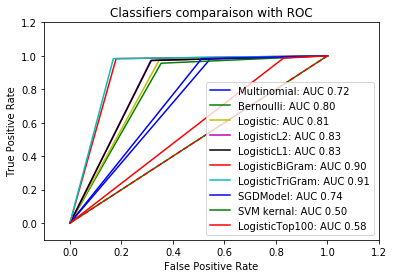

In [33]:
def formatt(x):
    if x == 'negative':
        return 0
    return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k','r','c','b','g','r']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(formatt), vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()